$dtauda=\dfrac{d\tau}{da}=\dfrac{dt}{ada}=\dfrac{1}{a\dot{a}}$

In [1]:
# solution.py
import numpy as np
import scipy

# Global fundamental constants
import astropy.constants as const
import astropy.units as u

const_c =  const.c.value

distance_gpc = 1 * u.Mpc
distance_km = distance_gpc.to(u.km)
time_gyr = 1 * u.Gyr
time_s = time_gyr.to(u.s)
# Unit conversion (1/H0 to Gyr)
transfer = (distance_km / time_s).value

# Reconstruct z as a vector function z = [dz0, dz1, dz2]
def function(t, z, kC1, O10, H0):
    # z[0] = z(t), z[1] = z'(t), z[2] = z''(t)
    dz1 = z[1]
    # Reduce the use of parentheses, separate into numerator and denominator
    numerator = (
        H0**4 * kC1 * O10**2 * (z[0]**4 + 1) +
        3 * H0**4 * O10**2 * z[0]**2 * (2 * kC1 - 3 * z[1]) +
        H0**4 * O10**2 * z[0]**3 * (4 * kC1 - 3 * z[1]) -
        3 * H0**4 * O10**2 * z[1] +
        5 * H0**2 * O10 * z[1]**3 -
        kC1 * z[1]**4 +
        H0**2 * O10 * z[0] * (4 * H0**2 * kC1 * O10 - 9 * H0**2 * O10 * z[1] + 5 * z[1]**3)
    )
    denominator = 2 * H0**2 * O10 * (1 + z[0])**2 * z[1]
    dz2 = numerator / denominator
    return [dz1, dz2]

# Solve the original equation for z(t) and z'(t)
def solution(log_kC1, O20, H0):
    # Unit conversion
    kC1 = 10**log_kC1 * transfer
    O10 = 1 - O20
    t0 = 1 / H0
    # Solution interval
    tspan = (t0, 0)
    tn = np.linspace(t0, 0, 100000)
    # Start from t0
    zt0 = [0, -H0]

    # Initial value given at t0
    z = scipy.integrate.solve_ivp(function, t_span=tspan, y0=zt0, t_eval=tn, method='RK45', args=(kC1, O10, H0))
    # z.y[0,:] = z(t), z.y[1,:] = z'(t)
    return z

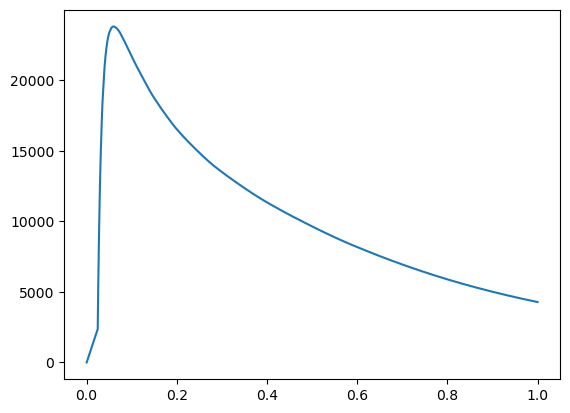

In [ ]:
import matplotlib.pyplot as plt
from astropy.constants import c

cc = c.to('km/s').value
z = solution(-3, 0.3, 70)
a = 1 / (1 + z.y[0,:])
dota = -z.y[1,:] * a ** 2
dtauda = 1 / (a * dota)
dtauda = dtauda * cc
a = np.append(a, 0)
dtauda = np.append(dtauda, 0)
plt.plot(a, dtauda)

In [3]:
# 将a和dtauda一起保存到同一个txt文件中，每行一个a值和对应的dtauda值
data = np.vstack((a, dtauda)).T
np.savetxt("temp.txt", data)

```fortran
function dtauda(this,a)

use results

implicit none
class(CAMBdata) :: this
real(dl), intent(in) :: a
real(dl) :: dtauda
real(dl) :: list(100000,2)
integer :: i, j, iostat

open(10, file='temp.txt')
do i=1,100000
    read(10, *, iostat=iostat) list(i,:)
    if (iostat /= 0) exit
end do
close(10)
j = sum(minloc(abs(a-list(:,1))))
if (j == 1) then
    dtauda = list(1,2)
else
    dtauda = (list(j,2)-list(j-1,2))/(list(j,1)-list(j-1,1))*(a-list(j,1))+list(j,2)
end if
write(*,*) 'a=', a, 'dtauda=', dtauda

end function dtauda
```